# Initialization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import numpy as np
import tensorflow as tf
from keras.models import load_model
import keras.backend as K
import json

import sys
sys.path.append("..")
from Cadex import Cadex
from LoanData import LoanData

Using TensorFlow backend.


In [2]:
def seed(numpy=0, tensorflow=0):
    np.random.seed(numpy)
    tf.set_random_seed(tensorflow)
    
def show_diff(candidate, modified):
    changed = (modified != candidate).values[0]
    display(pd.concat([data.unscale(candidate).iloc[:, changed], data.unscale(modified).iloc[:, changed]]) \
        .set_index([['Original', 'Modified']]).T)
    

## Loan the German training data

In [ ]:
seed()
data = LoanData(input_file='input_german.csv', labels_file='labels_german.csv', attributes_file='attributes_german.pickle')

In [4]:
data.train_input.shape, data.valid_input.shape

((800, 61), (200, 61))

In [6]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', 999):
    display(data.unscale(data.train_input))

,duration,credit,installment_percent,residence_duration,age,existing_credits,people_maintained,account_status_0..200 DM,account_status_< 0 DM,account_status_>= 200 DM,account_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account,credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken,purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_others,purpose_radio/television,purpose_repairs,purpose_retraining,savings_100..500 DM,savings_500..1000 DM,savings_< 100 DM,savings_>= 1000 DM,savings_unknown/ no savings account,sex_status_female: divorced/separated/married,sex_status_male: divorced/separated,sex_status_male: married/widowed,sex_status_male: single,debtors_co-applicant,debtors_guarantor,debtors_none,property_building society savings agreement,"property_car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/self-employed,job_skilled employee / official,job_unemployed/unskilled - non-resident,job_unskilled - resident,phone_none,"phone_yes, registered under the customers name",foreign_no,foreign_yes,employment_1..4 years,employment_4..7 years,employment_< 1 year,employment_>= 7 years,employment_unemployed
438,42.0,3394.0,4.0,4.0,65.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
893,36.0,5800.0,3.0,4.0,34.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
197,12.0,951.0,4.0,4.0,27.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
626,6.0,2116.0,2.0,2.0,41.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
697,12.0,926.0,1.0,2.0,38.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,45.0,3031.0,4.0,4.0,21.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
85,12.0,1412.0,4.0,2.0,29.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
530,36.0,2273.0,3.0,1.0,32.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
651,12.0,1922.0,4.0,2.0,37.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

## Take a look at the categorical and ordinal attributes

In [31]:
print(json.dumps(data.categorical_attributes, indent='  '))

[
  [
    "account_status_0..200 DM",
    "account_status_< 0 DM",
    "account_status_>= 200 DM",
    "account_status_no checking account"
  ],
  [
    "credit_history_all credits at this bank paid back duly",
    "credit_history_critical account",
    "credit_history_delay in paying off in the past",
    "credit_history_existing credits paid back duly till now",
    "credit_history_no credits taken"
  ],
  [
    "purpose_business",
    "purpose_car (new)",
    "purpose_car (used)",
    "purpose_domestic appliances",
    "purpose_education",
    "purpose_furniture/equipment",
    "purpose_others",
    "purpose_radio/television",
    "purpose_repairs",
    "purpose_retraining"
  ],
  [
    "savings_100..500 DM",
    "savings_500..1000 DM",
    "savings_< 100 DM",
    "savings_>= 1000 DM",
    "savings_unknown/ no savings account"
  ],
  [
    "sex_status_female: divorced/separated/married",
    "sex_status_male: divorced/separated",
    "sex_status_male: married/widowed",
    "sex_stat

In [32]:
data.ordinal_attributes

['existing_credits', 'people_maintained']

In [11]:
# We will use this to constrain 2 attributes to only go in the positive direction
direction_constraints = np.array([1.0 if i in ['age', 'people_maintained'] else 0.0 for i in data.input_columns])
direction_constraints

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Run CADEX on a single example

Load the fitted model from a file, and use it to generate several CADEX explanations for a single validation set sample. We generate multiple explanations simply by changing the value of `skip_attributes`.

In [8]:
model = load_model('model_german.h5')

# Initialize CADEX for this model
cadex = Cadex(model, categorical_attributes=data.categorical_attributes, 
    ordinal_attributes=data.ordinal_attributes, scale=data.scale, unscale=data.unscale)

In [22]:
# This sample should be predicted as class 0, i.e. REJECT
original = data.valid_input.iloc[[9], :]
pred = model.predict(original)
display(pred)
assert(pred[0, 0] > pred[0, 1])

array([[0.71979994, 0.28020006]], dtype=float32)

In [23]:
explanation, epoch = cadex.train(original, target=1, num_classes=2, num_changed_attributes=5, skip_attributes=0, 
    categorical_threshold=0.2, direction_constraints=direction_constraints)

show_diff(original, explanation)

,Original,Modified
duration,24.0,21.736325
credit,3123.0,2563.423245
installment_percent,4.0,3.769120
age,27.0,29.312573
account_status_< 0 DM,1.0,0.000000
account_status_no checking account,0.0,1.000000


In [26]:
explanation, epoch = cadex.train(original, target=1, num_classes=2, num_changed_attributes=5, skip_attributes=3, 
    categorical_threshold=0.2, direction_constraints=direction_constraints)

show_diff(original, explanation)

,Original,Modified
installment_percent,4.0,3.592054
age,27.0,31.086794
sex_status_female: divorced/separated/married,1.0,0.000000
sex_status_male: single,0.0,1.000000
property_building society savings agreement,1.0,0.000000
property_real estate,0.0,1.000000
employment_4..7 years,0.0,1.000000
employment_< 1 year,1.0,0.000000


In [28]:
explanation, epoch = cadex.train(original, target=1, num_classes=2, num_changed_attributes=5, skip_attributes=5, 
    categorical_threshold=0.2, direction_constraints=direction_constraints)

show_diff(original, explanation)

,Original,Modified
purpose_car (new),1.0,0.0
purpose_car (used),0.0,1.0
employment_4..7 years,0.0,1.0
employment_< 1 year,1.0,0.0


# Scan for CADEX

**NOTE - This takes a long time to run**

We iterate over all the validation set samples, and attempt to find 10 explanations for each by varying `skip_attributes`. The same is repeated for `num_changed_attributes` = [5, 7, 10].
The result of each scan is saved in a pickle file, and used for the rest of the evaluation.

You can avoid running the next 2 cells, as the data has already been serialized to 3 pickle files. Only run them if you wish to recreate them.

In [96]:
def scan_cadex(cadex, candidate, count=10, epochs=1500, num_changed_attributes=10, target_class=1, categorical_threshold=0.2):
    modifieds = list()
    for i in tqdm(range(count)):
        seed()
        modified, _ = cadex.train(candidate, target=target_class, num_classes=2, 
            num_changed_attributes=num_changed_attributes, skip_attributes=i, categorical_threshold=categorical_threshold, 
            direction_constraints=direction_constraints, max_epochs=epochs)
        modifieds.append(modified)
        
    return modifieds
    

In [ ]:
for attr in tqdm([5, 7, 10]):
    res = list()
    for i in tqdm(range(data.valid_input.shape[0])):
        K.clear_session()
        model = load_model('model_german.h5')
        cadex = Cadex(model, categorical_attributes=data.categorical_attributes, 
            ordinal_attributes=data.ordinal_attributes, scale=data.scale, unscale=data.unscale)
        candidate = data.valid_input.iloc[[i], :]
        predicted = model.predict(candidate)
        pred_class = np.argmax(predicted[0, :])
        modifieds = scan_cadex(cadex, candidate, epochs=1500, num_changed_attributes=attr, 
            target_class=1-pred_class)
        res.append({
            'candidate': candidate,
            'class': pred_class,
            'modifieds': modifieds
        })
    pickle.dump(res, open(f'fullscan{attr}.pickle', 'wb'))

# Number of solutions
Plot number of solutions found by `num_changed`.

In [29]:
scanned = pickle.load(open('fullscan10.pickle', 'rb'))
count10 = [len([j for j in i['modifieds'] if j is not None]) for i in scanned]
scanned = pickle.load(open('fullscan7.pickle', 'rb'))
count7 = [len([j for j in i['modifieds'] if j is not None]) for i in scanned]
scanned = pickle.load(open('fullscan5.pickle', 'rb'))
count5 = [len([j for j in i['modifieds'] if j is not None]) for i in scanned]

In [30]:
df = pd.concat([
    pd.DataFrame({'x': count10, 'n': '10'}),
    pd.DataFrame({'x': count7, 'n': '7'}),
    pd.DataFrame({'x': count5, 'n': '5'})
])

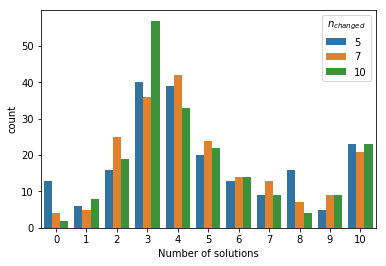

In [31]:
sns.countplot(data=df, x='x', hue='n', hue_order=['5', '7', '10'])
plt.xlabel('Number of solutions')
plt.legend(title='$n_{changed}$')
plt.show()

# Compare with training set counterfactuals

For each validation set item, we find the nearest counterfactual from the training set using L2 distance, and compare it to the CADEX explanation with the lowest distance from the original.

In [32]:
scanned = pickle.load(open('fullscan5.pickle', 'rb'))
for i in scanned:
    try:
        i['modifieds'] = pd.concat(i['modifieds'])
    except:
        i['modifieds'] = None

candidates = data.train_input[data.train_labels.Good == 1]

In [33]:
def num_changed(a, b):
    return np.count_nonzero(a.values != b.values, axis=1 if b.shape[0] > 1 else None)

def distance(a, b):
    return np.sum(np.square(a.values - b.values), axis=1 if b.shape[0] > 1 else None)

def counterfact(source, candidates):
    i = np.argmin(distance(source, candidates))
    return candidates.iloc[[i], :]


In [34]:
counter = []
for s in scanned:
     if s['class'] == 0:
        c = s['candidate']
        modifieds = s['modifieds']
        if modifieds is not None:
            best = np.argmin(distance(c, modifieds))
            m = modifieds.iloc[[best], :]
        else:
            m = None
        cf = counterfact(c, candidates) 
        counter.append({
            'cf': cf,
            'dist_m': distance(c, m) if m is not None else None,
            'dist_cf': distance(c, cf) if cf is not None else np.NaN
        })

In [35]:
dist_m = [i['dist_m'] for i in counter if i['dist_m'] is not None]
dist_cf = [i['dist_cf'] for i in counter]

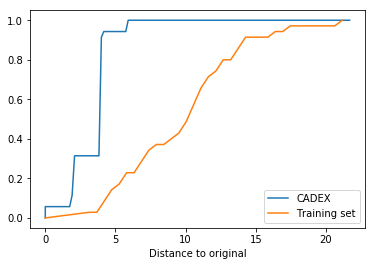

In [36]:
mx = np.max(dist_cf)
y, x = np.histogram(dist_m, bins=len(dist_m))
y = y / np.sum(y)
x = x[:len(y)]
y = np.append([0], y)
y = np.cumsum(y)
x = np.append([0], x)
x = np.append(x, [mx])
y = np.append(y, [1])
plt.plot(x, y, label='CADEX')
y, x = np.histogram(dist_cf, bins=len(dist_cf))
y = y / np.sum(y)
x = x[:len(y)]
y = np.append([0], y)
y = np.cumsum(y)
x = np.append([0], x)
plt.plot(x, y, label='Training set')
plt.xlabel('Distance to original')
plt.legend(loc='lower right')
plt.show()

# Compare with SHAP
For each validation set sample, calculate the

In [37]:
import shap

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [38]:
scanned = pickle.load(open('fullscan5.pickle', 'rb'))
K.clear_session()
model = load_model('model_german.h5')

# Initialize CADEX for this model
cadex = Cadex(model, categorical_attributes=data.categorical_attributes, 
    ordinal_attributes=data.ordinal_attributes, scale=data.scale, unscale=data.unscale)

In [39]:
explainer = shap.KernelExplainer(lambda x: cadex.original_model.predict(x), data.train_input, link="logit")

Using 800 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [ ]:
for s in tqdm(scanned):
    s['candidate_shap'] = explainer.shap_values(s['candidate'], nsamples=100)


In [45]:
shap_zero = []
for s in scanned:
    c = s['candidate']
    shap_c = s['candidate_shap'][s['class']]
    for m in s['modifieds']:
        if m is not None:
            ind = ((c != m) & (c != 1) & (shap_c == 0)).values[0]
            shap_zero.append(np.count_nonzero(ind))


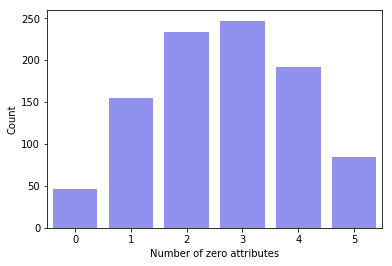

In [46]:
sns.countplot(shap_zero, color='#8080ff')
plt.xlabel('Number of zero attributes')
plt.ylabel('Count')
plt.show()

# Transferability

Measure how often we can find a CADEX explanation which would be adversarial on a completely different model trained on the same data. We use a random forest classifier, and repeat the experiment 100 times with different seeds.

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
scanned = pickle.load(open('fullscan10.pickle', 'rb'))
trans1, trans2 = 0, 0
for seed_id in tqdm(range(100)):
    seed(seed_id)
    forest = RandomForestClassifier(n_estimators=100)
    forest.fit(data.train_input, data.train_labels.Good)
    pred = forest.predict(data.valid_input)

    def f():                                                                           
        for i in range(pred.shape[0]):                                                 
            if scanned[i]['class'] == pred[i]:
              try:                                                                     
                pred_mod = forest.predict(pd.concat(scanned[i]['modifieds']))          
                yield (np.array(pred_mod) == (1 - pred[i])).any(), \
                    np.count_nonzero(np.array(pred_mod) == (1 - pred[i])) > 1
              except:                                                                  
                pass      
    l = list(f())
    l1 = [i[0] for i in l]
    l2 = [i[1] for i in l]
    x1, y1 = np.count_nonzero(l1), len(l1)
    x2, y2 = np.count_nonzero(l2), len(l2)
    trans1 += x1/y1
    trans2 += x2/y2
trans1 /= 100
trans2 /= 100                                                                                  

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


In [54]:
# Display in how many cases at least one CADEX explanation was adversarial on the random forest model, 
# and in how many cases at least 2 (as percentage)
trans1, trans2

(0.9523881100067887, 0.8760068845479299)